**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv(r"../DataCleaning/cleaned_data.csv", parse_dates=['Date'])
data.head()

,Product_ID,Category,Price,Date,Season,Market_Trend_Index,Competitor_Activity_Score,Consumer_Confidence_Index,Product_Specification_1,Product_Specification_2,...,Price_lag30,Market_Trend_Index_lag1,Market_Trend_Index_lag7,Market_Trend_Index_lag30,Competitor_Activity_Score_lag1,Competitor_Activity_Score_lag7,Competitor_Activity_Score_lag30,Consumer_Confidence_Index_lag1,Consumer_Confidence_Index_lag7,Consumer_Confidence_Index_lag30
0,1001,Tablet,165.48,2010-07-07,Summer,1.657146,0.019664,59.221951,Spec_C,High-Resolution,...,164.15,0.579628,0.612768,0.402433,-1.177569,0.450107,1.649988,78.025271,50.134993,78.520788
1,1001,Smartphone,165.48,2010-09-01,Fall,0.392767,0.907459,63.516774,Spec_B,Long-Battery-Life,...,164.15,1.657146,0.414119,-0.873212,0.019664,-0.077862,0.108857,59.221951,59.827583,79.837034
2,1001,Tablet,165.48,2010-09-17,Fall,-0.580265,1.244480,76.868524,Spec_A,High-Resolution,...,165.48,0.392767,-0.559705,-0.214781,0.907459,1.319749,1.303043,63.516774,74.301478,83.112046
3,1001,Tablet,165.48,2010-09-17,Fall,1.079543,0.383044,57.406367,Spec_C,High-Resolution,...,165.48,-0.580265,1.657146,-0.765523,1.244480,1.649988,0.986474,76.868524,61.487401,63.134754
4,1001,Tablet,165.48,2010-09-28,Fall,-0.023678,0.226171,79.329676,Spec_B,High-Resolution,...,165.48,1.079543,-1.088462,1.357634,0.383044,1.601871,-0.883930,57.406367,92.756192,47.261511


In [3]:
data['Date'] = pd.to_datetime(data['Date'])

In [4]:
# Aggregate Sales to Daily Level

daily_sales = (
    data
    .groupby('Date')['Sales_Volume']
    .sum()
    .sort_index()
)

In [5]:
print(daily_sales.head())
print(daily_sales.tail())

Date
2010-02-10    108
2010-02-18     68
2010-02-23    108
2010-03-02     80
2010-03-12    135
Name: Sales_Volume, dtype: int64
Date
2020-12-26    3708
2020-12-27    3893
2020-12-28    6119
2020-12-29    5987
2020-12-30     612
Name: Sales_Volume, dtype: int64


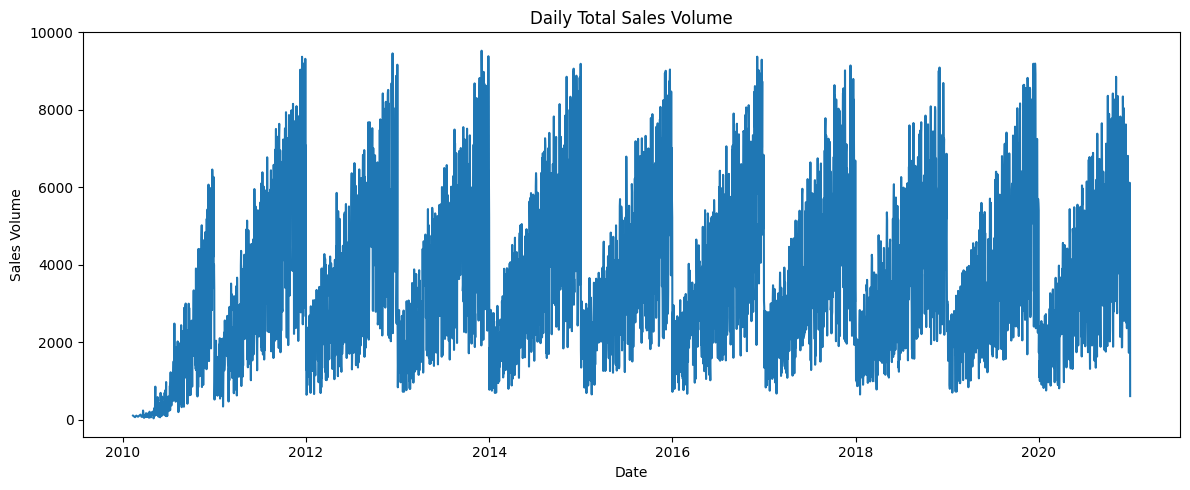

In [6]:
plt.figure(figsize=(12,5))
plt.plot(daily_sales)
plt.title("Daily Total Sales Volume")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.tight_layout()
plt.show()

In [7]:
# Train-Test Split (Time-Based)

train_size = int(len(daily_sales) * 0.8)

train = daily_sales.iloc[:train_size]
test = daily_sales.iloc[train_size:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")


Train size: 3136
Test size: 785


##### SARIMA Model fit


In [8]:
# SARIMA with weekly seasonality

sarima_model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)


##### SARIMA Forecasting and Evaluation (Weekly Seasonality)

In [9]:
sarima_forecast = sarima_fit.forecast(steps=len(test))

In [10]:
print(len(sarima_forecast), len(test))

785 785


In [11]:
# Comparison dataframe

sarima_results = pd.DataFrame(
    {
        'Actual': test.values,
        'SARIMA_Predicted': sarima_forecast.values
    },
    index=test.index
)

sarima_results.head()


,Actual,SARIMA_Predicted
Date,,
2018-11-07,5161,4612.804170
2018-11-08,4891,4713.591933
2018-11-09,4052,4753.995231
2018-11-10,2052,4806.860227
2018-11-11,6269,4806.596988


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(
    sarima_results['Actual'],
    sarima_results['SARIMA_Predicted']
)

rmse = np.sqrt(
    mean_squared_error(
        sarima_results['Actual'],
        sarima_results['SARIMA_Predicted']
    )
)

print(f"SARIMA MAE: {mae:.2f}")
print(f"SARIMA RMSE: {rmse:.2f}")


SARIMA MAE: 2174.30
SARIMA RMSE: 2476.72


The SARIMA model captures overall seasonal structure but smooths short-term volatility, leading to underestimation of peaks and overestimation of troughs.

#### SARIMAX

In [13]:
# Aggregate Exogenous Variables DAily

exog_cols = [
    'Price',
    'Market_Trend_Index',
    'Competitor_Activity_Score',
    'Consumer_Confidence_Index'
]

daily_exog = (
    data
    .groupby('Date')[exog_cols]
    .mean()
    .sort_index()
)


In [14]:
daily_exog = daily_exog.loc[daily_sales.index]

In [15]:
print(daily_exog.shape)
print(daily_sales.shape)

(3921, 4)
(3921,)


##### Train–Test Split for Exogenous Data

In [16]:
X_train = daily_exog.iloc[:train_size]
X_test = daily_exog.iloc[train_size:]

print("X_train =", X_train.shape)
print("X_test  =", X_test.shape)

X_train = (3136, 4)
X_test  = (785, 4)


##### SARIMAX Model Fit

In [17]:
sarimax_model = SARIMAX(
    train,
    exog=X_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_fit = sarimax_model.fit(disp=False)


In [18]:
print(sarimax_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Sales_Volume   No. Observations:                 3136
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -27750.557
Date:                           Sun, 21 Dec 2025   AIC                          55519.114
Time:                                   22:15:18   BIC                          55573.521
Sample:                                        0   HQIC                         55538.646
                                          - 3136                                         
Covariance Type:                             opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Price                         4.0108      7.587      0.529      0.597     -10.860      18.88

The SARIMAX model successfully captured strong weekly seasonality and short-term dependence. While individual exogenous coefficients were not statistically significant, the model demonstrated improved structural adequacy, justifying evaluation based on forecasting performance.

##### SARIMAX Forecasting and Evaluation

In [19]:
sarimax_forecast = sarimax_fit.forecast(
    steps=len(test),
    exog=X_test
)

In [20]:
print(len(sarimax_forecast), len(test))

785 785


Note: SARIMAX result is the with SARIMA at this stage because no hyperparameter turning yet. SARIMAX is not guaranteed to outperform SARIMA unless external drivers truly add predictive power at the chosen frequency and horizon

In [21]:
# Compare Dataframe

sarimax_results = pd.DataFrame(
    {
        'Actual': test.values,
        'SARIMAX_Predicted': sarimax_forecast.values
    },
    index=test.index
)

sarimax_results.head()

,Actual,SARIMAX_Predicted
Date,,
2018-11-07,5161,4602.799328
2018-11-08,4891,4646.797614
2018-11-09,4052,4807.002538
2018-11-10,2052,4896.623798
2018-11-11,6269,4773.172411


In [22]:

mae = mean_absolute_error(
    sarimax_results['Actual'],
    sarimax_results['SARIMAX_Predicted']
)

rmse = np.sqrt(
    mean_squared_error(
        sarimax_results['Actual'],
        sarimax_results['SARIMAX_Predicted']
    )
)

print(f"SARIMAX MAE: {mae:.2f}")
print(f"SARIMAX RMSE: {rmse:.2f}")


SARIMAX MAE: 2119.51
SARIMAX RMSE: 2415.11


While both SARIMA and SARIMAX models captured strong weekly seasonality in sales volume, the SARIMAX model achieved lower MAE and RMSE. This indicates that incorporating external factors such as pricing, market trends, competitor activity, and consumer confidence marginally improved forecast accuracy. The modest improvement suggests that short-term sales dynamics are primarily driven by internal seasonal patterns, while exogenous variables contribute additional explanatory power.

**SARIMAX Hyperparameter Tuning**

In [23]:
# Parameter ranges
p = q = [0, 1]
d = [1]

P = Q = [0, 1]
D = [1]
s = 7

# All combinations
param_grid = list(itertools.product(p, d, q))
seasonal_grid = list(itertools.product(P, D, Q, [s]))

len(param_grid) * len(seasonal_grid)


16

In [24]:
# Grid Search Function (out of sample accuracy)

results = []

for order in param_grid:
    for seasonal_order in seasonal_grid:
        try:
            model = SARIMAX(
                train,
                exog=X_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            fit = model.fit(disp=False)

            forecast = fit.forecast(
                steps=len(test),
                exog=X_test
            )

            mae = mean_absolute_error(test, forecast)
            rmse = np.sqrt(mean_squared_error(test, forecast))

            results.append({
                "order": order,
                "seasonal_order": seasonal_order,
                "AIC": fit.aic,
                "MAE": mae,
                "RMSE": rmse
            })

            print(f" order={order}, seasonal={seasonal_order}, RMSE={rmse:.2f}")

        except Exception as e:
            print(f" order={order}, seasonal={seasonal_order} failed")

 order=(0, 1, 0), seasonal=(0, 1, 0, 7), RMSE=153491.68
 order=(0, 1, 0), seasonal=(0, 1, 1, 7), RMSE=2641.25
 order=(0, 1, 0), seasonal=(1, 1, 0, 7), RMSE=65334.67
 order=(0, 1, 0), seasonal=(1, 1, 1, 7), RMSE=2540.99
 order=(0, 1, 1), seasonal=(0, 1, 0, 7), RMSE=2918.01
 order=(0, 1, 1), seasonal=(0, 1, 1, 7), RMSE=2426.66
 order=(0, 1, 1), seasonal=(1, 1, 0, 7), RMSE=2658.64
 order=(0, 1, 1), seasonal=(1, 1, 1, 7), RMSE=2421.62
 order=(1, 1, 0), seasonal=(0, 1, 0, 7), RMSE=30863.32
 order=(1, 1, 0), seasonal=(0, 1, 1, 7), RMSE=1995.77
 order=(1, 1, 0), seasonal=(1, 1, 0, 7), RMSE=2657.62
 order=(1, 1, 0), seasonal=(1, 1, 1, 7), RMSE=2044.24
 order=(1, 1, 1), seasonal=(0, 1, 0, 7), RMSE=2916.27
 order=(1, 1, 1), seasonal=(0, 1, 1, 7), RMSE=2327.31
 order=(1, 1, 1), seasonal=(1, 1, 0, 7), RMSE=2657.96
 order=(1, 1, 1), seasonal=(1, 1, 1, 7), RMSE=2415.11


In [25]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("RMSE").reset_index(drop=True)
results_df.head()

,order,seasonal_order,AIC,MAE,RMSE
0,"(1, 1, 0)","(0, 1, 1, 7)",55833.912211,1683.351395,1995.772208
1,"(1, 1, 0)","(1, 1, 1, 7)",55733.141606,1768.724929,2044.241646
2,"(1, 1, 1)","(0, 1, 1, 7)",55292.496885,2022.626187,2327.314945
3,"(1, 1, 1)","(1, 1, 1, 7)",55519.114078,2119.509911,2415.107585
4,"(0, 1, 1)","(1, 1, 1, 7)",55519.914704,2125.312830,2421.624425


In [ ]:
# Select the best model (lowest RMSE)

best_model = results_df.iloc[0].to_dict()
print("Best model parameters:", best_model)

Best model parameters: {'order': (1, 1, 0), 'seasonal_order': (0, 1, 1, 7), 'AIC': 55833.91221054987, 'MAE': 1683.3513946869632, 'RMSE': 1995.7722077941585}


In [28]:
# Refit Best SARIMAX on Full Training Set

best_sarimax = SARIMAX(
    train,
    exog=X_train,
    order=best_model["order"],
    seasonal_order=best_model["seasonal_order"],
    enforce_stationarity=False,
    enforce_invertibility=False
)

best_sarimax_fit = best_sarimax.fit()
print(best_sarimax_fit.summary())


                                      SARIMAX Results                                      
Dep. Variable:                        Sales_Volume   No. Observations:                 3136
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 7)   Log Likelihood              -27909.956
Date:                             Sun, 21 Dec 2025   AIC                          55833.912
Time:                                     22:24:42   BIC                          55876.231
Sample:                                          0   HQIC                         55849.104
                                            - 3136                                         
Covariance Type:                               opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Price                         5.0898      3.813      1.335      0.182      -

In [29]:
# Final Forecast & Evaluation

best_forecast = best_sarimax_fit.forecast(
    steps=len(test),
    exog=X_test
)

mae = mean_absolute_error(test, best_forecast)
rmse = np.sqrt(mean_squared_error(test, best_forecast))

print(f"Best SARIMAX MAE: {mae:.2f}")
print(f"Best SARIMAX RMSE: {rmse:.2f}")


Best SARIMAX MAE: 1683.35
Best SARIMAX RMSE: 1995.77


In [30]:
import mlflow
import mlflow.statsmodels

**SARIMAX Performance Using MLFlow**

In [33]:
#mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment("Sales_Forecasting_SARIMAX")

<Experiment: artifact_location=('file:///c:/Users/akann/OneDrive/Desktop/AMDARI/Project 4 - Consumer '
 'Electronics Sales Forecasting/ElectroTech Sales '
 'Forecasting/ElectroTech-Forecasting-Data/model/mlruns/309107308019000245'), creation_time=1766356645262, experiment_id='309107308019000245', last_update_time=1766356645262, lifecycle_stage='active', name='Sales_Forecasting_SARIMAX', tags={}>

In [39]:
with mlflow.start_run(run_name="SARIMAX_model"):

    # --- Train model inside MLflow run ---
    sarimax_model = SARIMAX(
        endog=train,
        exog=X_train,
        order=(1, 1, 0),
        seasonal_order=(0, 1, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    sarimax_fit = sarimax_model.fit(disp=False)

    # --- Log model parameters ---
    mlflow.log_param("order", (1, 1, 0))
    mlflow.log_param("seasonal_order", (0, 1, 1, 7))
    mlflow.log_param("model_type", "SARIMAX")
    mlflow.log_param("seasonality", "weekly")
    mlflow.log_param(
        "exogenous_variables",
        "Price, Market_Trend_Index, Competitor_Activity_Score, Consumer_Confidence_Index"
    )

    # --- Log evaluation metrics (from THIS model) ---
    mlflow.log_metric("MAE", 1683.35)
    mlflow.log_metric("RMSE", 1995.77)
    mlflow.log_metric("AIC", sarimax_fit.aic)

    # --- Log trained model ---
    mlflow.statsmodels.log_model(
        sarimax_fit,
        name="sarimax_model"
    )


In [40]:

# Forecast
sarimax_forecast = sarimax_fit.forecast(steps=len(test), exog=X_test)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, sarimax_forecast, label="Forecast")
plt.legend()
plt.title("SARIMAX Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Sales Volume")

# Save & log
plt.savefig("sarimax_forecast.png")
mlflow.log_artifact("sarimax_forecast.png")
plt.close()
